# Introduction to Time Series Forecasting

***Summary***
- Time Series Features (Seasonality, Trends, Holidays)
- Simple & Triple Exponential Smoothing (statsmodel)
- ARIMA & SARIMA (statsmodel)
- Prophet (Facebook's open source forecasting library)

#### Table of Contents ####
I. [Load Datasets](#load-datasets) <br>
II. [What is a Time Series?](#what-is-a-time-series) <br>
III. [No Seasonality and (Weak) Trend](#no-seasonality-weak-trend) <br>
IV. [Seasonality and Trend](#seasonality-and-trend) <br>
V. [Seasonality, Trend, and Holiday Spikes](#seasonality-trend-and-holiday) <br>
VI. [Seasonality and Multi-trend](#seasonality-and-multi-trend) <br>

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

<a id='load-datasets'></a>
## I. Load Datasets

- Avocado Sales: https://hassavocadoboard.com/
- Flight Passengers: https://github.com/mwaskom/seaborn-data/blob/master/flights.csv
- US Gas Prices: https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=EMM_EPMR_PTE_NUS_DPG&f=W
- SF Vehicle Theft: https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry

In [2]:
# Read in datasets
flights = sns.load_dataset('flights')
avocado = pd.read_csv('data-sets/avocado_sales.csv')
gas = pd.read_csv('data-sets/gasoline.csv')
vehicle = pd.read_csv('data-sets/vehicle_theft.csv')

In [3]:
# Preprocessing of datasets
def convert_to_datetime(df, freq):
    df["Date"]= pd.to_datetime(df["Date"])
    df.sort_values(by ='Date', ascending = True, inplace = True)
    df.set_index("Date", inplace = True)
    output_df = df.asfreq(freq)
    return output_df

# Process flights
flights['Date'] = flights['year'].astype(str) + '-'+ flights['month'].astype(str)
flights.drop(columns = ['year', 'month'], inplace = True)
flights = convert_to_datetime(flights, 'MS')

# Process avocado
avocado = convert_to_datetime(avocado, 'W-Sun')

# Process gas
gas = convert_to_datetime(gas, 'W-MON')

# Process vehicle
vehicle = convert_to_datetime(vehicle, 'D')

<a id='what-is-a-time-series'></a>
## II. What is a Time Series?
A time series is a data set ordered by time. Usually the time between observations is constant (ie daily, week, or monthly). 

In [4]:
print("Gas Prices:")
display(gas)

print("Flight Passengers")
display(flights)

print("Avocado Sales:")
display(avocado)

print("Reported Vehicle Thefts:")
display(vehicle)

Gas Prices:


,Price
Date,
2010-01-04,2.665
2010-01-11,2.751
2010-01-18,2.739
2010-01-25,2.705
2010-02-01,2.661
...,...
2020-05-04,1.789
2020-05-11,1.851
2020-05-18,1.878


Flight Passengers


,passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


Avocado Sales:


,Units Sold
Date,
2015-01-04,31937187.88
2015-01-11,29733071.63
2015-01-18,29756578.85
2015-01-25,29026679.70
2015-02-01,45396358.48
...,...
2020-02-23,46881143.67
2020-03-01,45482304.61
2020-03-08,46088050.66


Reported Vehicle Thefts:


,Reported Incidents
Date,
2006-01-01,22
2006-01-02,13
2006-01-03,24
2006-01-04,12
2006-01-05,13
...,...
2018-05-11,2
2018-05-12,1
2018-05-13,1


### i. No seasonality and (weak) trend

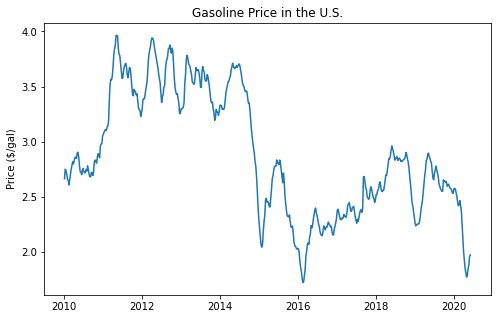

In [5]:
plt.rcParams['figure.figsize'] = (8,5)

plt.title('Gasoline Price in the U.S.')
plt.ylabel('Price ($/gal)')
plt.plot(gas['Price']);

### ii. Seasonality and trend

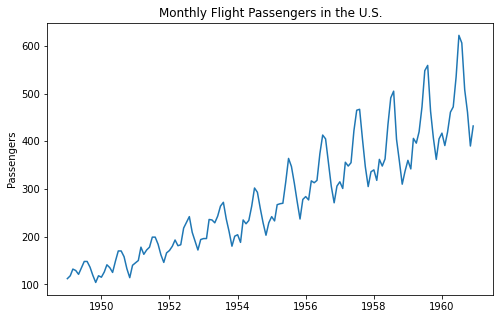

In [6]:
plt.title('Monthly Flight Passengers in the U.S.')
plt.ylabel('Passengers')
plt.plot(flights['passengers']);

### iii. Seasonality, trend, and holiday spikes

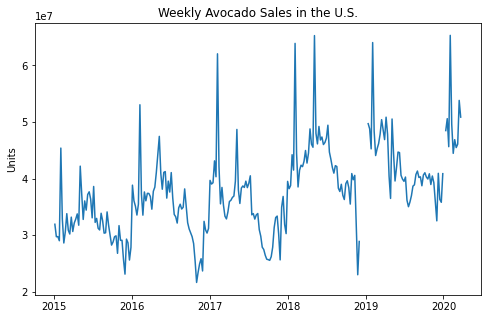

In [7]:
plt.title('Weekly Avocado Sales in the U.S.')
plt.ylabel('Units')
plt.plot(avocado['Units Sold']);

### iv. Seasonality and  multi-trend

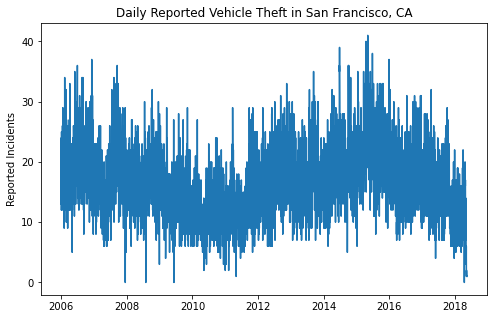

In [8]:
plt.title('Daily Reported Vehicle Theft in San Francisco, CA')
plt.ylabel('Reported Incidents')
plt.plot(vehicle['Reported Incidents']);

# Selecting a Time Series Method

There's many forecasting methods implemented in Python libraries. It's important to understand how to match the underlying shape of the time series to the forecast model for highest accuracy. This section shows how to build popular forecast models for typical time series datasets.

* **No seasonality or (weak) trend**
    - Simple Exponential Smoothing (gas prices)
    - ARIMA (gas prices)
* **Seasonality and trend**
    - Triple Exponential Smoothing (flights)
    - SARIMA (flights)
* **Seasonality, trend, and holiday spikes**
    - Prophet (avocado)
* **Seasonality and multi-trend**
    - Prophet (vehicle theft)

<a id='no-seasonality-weak-trend'></a>
## III. No Seasonality and (Weak) Trend

When there is no seasonality or trend, the best we can do is predict a direction using Simple Exponentially Smoothing or ARIMA.

### i. Simple Exponential Smoothing

In an exponential smoothing model, the next period forecast is a weighted average of the recent time series values. The forecast weights increase exponentially with time, so more recently observed forecasts contribute more to the forecast. A single parameter, `smoothing_level`, controls the rate that the weights increase and the forecast's responsiveness.

- `smoothing_level`: a parameter (also called alpha) between 0 and 1 that determines how to weigh previous observations. A value closer to 1 means the model pays more attention to recent observations and a value closer to 0 tells the model to use older observations.

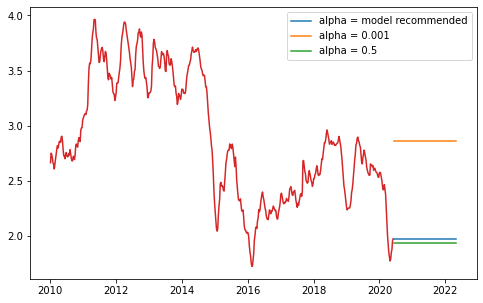

In [9]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model = SimpleExpSmoothing(gas['Price'])

# Fit the models
fit1 = model.fit()  # the library find a good alpha to use
fit2 = model.fit(smoothing_level = .001)
fit3 = model.fit(smoothing_level = .5)

# Forecast 100 weeks into the future
pred1 = fit1.forecast(100)
pred2 = fit2.forecast(100)
pred3 = fit3.forecast(100)

plt.plot(pred1, label = 'alpha = model recommended')
plt.plot(pred2, label = 'alpha = 0.001')
plt.plot(pred3, label = 'alpha = 0.5')
plt.plot(gas['Price'])
plt.legend();

References/Additional Reading: https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

### ii. ARIMA

ARIMA stands for AutoRegressive Integrated Moving Average. The ARIMA model first removes autocorrelation in the time series and then uses a regression model to make a a forecast off of recent observations and forecast error.

- `order`: a set of parameters `(p, d, q)` specifing the order of the autoregressive, moving average, and differencing terms.
    - `p` : The number of past observations to use or autogressive order. (If you are forecasting for week 5 and p = 2, the model would use the week 3 and 4 time series values.)
    - `d` : The order of differencing. The ARIMA model works best if the time series values are not correlated. This autocorrelation can be removed by taking each observation and subtracting the previous observation. (Subtract the week 1 value from week 2, subtract week 2 from week 3 and so on to create a new time series. If the new time series is still autocorrelated, we can repeat the differencing process again.)
    - `q` : The order of the moving average term. The ARIMA model uses the error between the value the forecast model would have predicted and the actual observed value for past time series values. We use q to specify the number of past error terms to include in the model.
    
In the example below, arbitrary values for the `order` were selected but methods exist to select optimal parameter values.

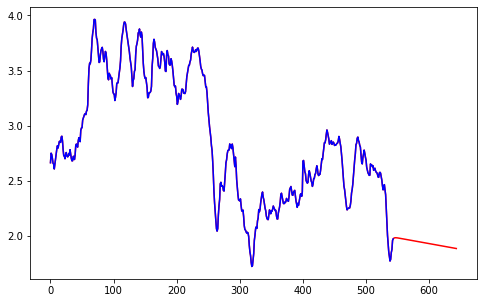

In [10]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(gas['Price'], order=(1,1,1))
model_fit = model.fit()
output = model_fit.forecast(100)

plt.plot(np.concatenate([np.asarray(gas['Price']),output[0]]), c = 'r')
plt.plot(np.asarray(gas['Price']), c = 'b');

References/Additional Reading: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

<a id='seasonality-trend'></a>
## IV. Seasonality and Trend

Most time series can be broken down into trend and seasonality components. The **trend** is an overall increase or decrease over multiple periods and **seasonality** is a recurring pattern that repeats periodically.

Both trend and seasonality can be classified as **additive** or **multiplicative**. Graphs of the different types of trend and seasonality can be seen below:

![seasonal-and-trend-types](assets/seasonality-and-trend-types.png)

### i. Triple Exponential Smoothing (Holt-Winters Seasonal)

The Triple Exponential Smoothing model (TES) is an extension of the Simple Exponential Smoothing (SES) model to account for seasonality. Like SES we use exponentially increasing weights to make forecasts, but instead of just using the values of the time series themselves, we quantify the trend and seasonal components and exponentially weight these factors when making a forecast. As a result, we have the additional `smoothing_slope` and `smoothing_seasonal` parameters which control how much the most recent trend and seasonality factors are weighted.   

##### `ExponentialSmoothing(...)`
- `trend` : {"additive", "multiplicative", None} 
    Type of trend component.

- `seasonal` : {"additive", "multiplicative", None}
    Type of seasonal component.

- `seasonal_periods` :
    The number of periods in a complete seasonal cycle, e.g., 4 for
    quarterly data or 7 for daily data with a weekly cycle.
    
##### `ExponentialSmoothing().fit(...)`
- `smoothing_level` : 
    Parameter (also called alpha) between 0 and 1 that is the same as in the simple exponential smoothing model.
- `smoothing_slope` : 
    Parameter (also called beta) between 0 and 1 that controls the trend. If alpha is closer to 1, the model pays attention to the more recent trend. 
- `smoothing_seasonal` : 
    Parameter (also called gamma) between 0 and 1 that controls the seasonality. If gamma is closer to 1, the model pays attention to more recent seasonality cycle's shape. 

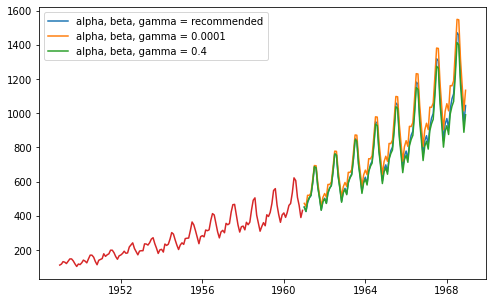

In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(flights['passengers'], 
                             trend = 'multiplicative',
                             seasonal = 'multiplicative',
                             seasonal_periods = 12)

# Fit models
fit1 = model.fit(optimized = True) #If optimized is True, model recommends parameters.
fit2 = model.fit(smoothing_level = 0.0001, smoothing_slope = 0.0001, smoothing_seasonal = 0.0001)
fit3 = model.fit(smoothing_level = 0.4, smoothing_slope = 0.4, smoothing_seasonal = 0.4)

# Forecast 96 months out
pred1 = fit1.forecast(96)
pred2 = fit2.forecast(96)
pred3 = fit3.forecast(96)

plt.plot(pred1, label = 'alpha, beta, gamma = recommended')
plt.plot(pred2, label = 'alpha, beta, gamma = 0.0001')
plt.plot(pred3, label = 'alpha, beta, gamma = 0.4')
plt.plot(flights['passengers'])
plt.legend();

References/Additional Reading: 
- https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/
- https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

### ii. SARIMA

SARIMA stands for Seasonal AutoRegressive Integrated Moving Average. The SARIMA model is the same as the ARIMA model, however, it accounts for seasonality by looking at the corresponding observations across cycles. For example to forecast next December, the SARIMA model might use the value from the last few Decembers, perform differencing over past December observations, and use historical December errors. 

- `order`: a set of parameters `(p, d, q)` specifing the order of the autoregressive, moving average, and differencing terms. Same as the ARIMA model.
- `seasonal_order`: a set of parameters `(P, D, Q, m)` for the seasonal cycles. The parameters (P,D,Q) have the same meaning as in the ARIMA models but for the seasonal components. 
    - `m` : Number of periods in a complete seasonal cycle. (Called seasonal_periods in triple exponential smoothing)

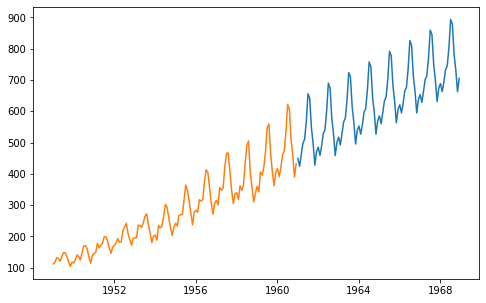

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# define model
model = SARIMAX(flights['passengers'], order=(1,1,1), seasonal_order=(1,1,1,12))

# fit model
model_fit = model.fit()

pred = model_fit.forecast(96)
plt.plot(pred)
plt.plot(flights['passengers']);

References/Additional Reading:
- https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
- https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

<a id='seasonality-trend-holiday'></a>
## V. Seasonality, Trend, and Holiday Spikes

### i. Prophet Basics

Prophet is open source library for time series forecasting developed by Facebook. Prophet builds a model composed of a trend seasonality, and holiday components by fitting a curve through the time series data points.

Unique features include:
- Adding holiday effects (Superbowl, Christmas, New Years, 4th of July)
- Specify points where the trend change
- Adust seasonality smoothness

"Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well." - https://github.com/facebook/prophet

In [13]:
from fbprophet import Prophet

# Prophet requires the time series to be a 2 column pd.dataframe with the Date as 'ds' and the values as 'y'.
avocado_prophet = avocado.reset_index().rename(columns = {'Date':'ds', 'Units Sold':'y'})
avocado_prophet.head()

,ds,y
0,2015-01-04,31937187.88
1,2015-01-11,29733071.63
2,2015-01-18,29756578.85
3,2015-01-25,29026679.70
4,2015-02-01,45396358.48


In [14]:
# Initialize the Prophet model instance.
m = Prophet(weekly_seasonality=False, daily_seasonality=False)

# Fit the model on the time series.
m.fit(avocado_prophet)

# Create a DataFrame of future dates to create forecasts for. 
future = m.make_future_dataframe(periods=52, freq = 'W-Sun')
future.tail()

,ds
320,2021-02-21
321,2021-02-28
322,2021-03-07
323,2021-03-14
324,2021-03-21


In [15]:
# Use the model to create forecasts.
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
315,2021-01-17,5.098946e+07,4.562690e+07,5.626924e+07
316,2021-01-24,5.462370e+07,4.917522e+07,6.033256e+07
317,2021-01-31,5.720218e+07,5.207428e+07,6.270123e+07
318,2021-02-07,5.685091e+07,5.138250e+07,6.212348e+07
319,2021-02-14,5.358332e+07,4.807094e+07,5.886925e+07
320,2021-02-21,4.965851e+07,4.399697e+07,5.526021e+07
321,2021-02-28,4.779156e+07,4.253634e+07,5.331919e+07
322,2021-03-07,4.880661e+07,4.307450e+07,5.437816e+07
323,2021-03-14,5.103406e+07,4.549604e+07,5.642348e+07
324,2021-03-21,5.206884e+07,4.685176e+07,5.684027e+07


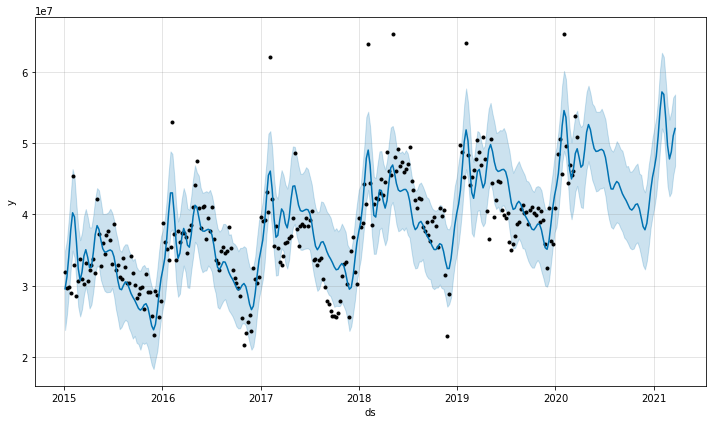

In [16]:
# Plot the forecasts. Uncertainity intervals of width 80% are show by default as the shaded blue region.
fig1 = m.plot(forecast)

### ii. (Prophet) Adding Holiday Effects
You might notice from the graphs above that Prophet automatically accounts for outliers. However, this means the model will miss the **holiday spikes** in avocado sales around the Superbowl and the 4th of July. The Prophet API provides a convenient method to add holiday effects or other floating days that might explain sudden changes in the time series. Let's add features to the model to account for these holiday effects.

In [17]:
# lower_window = -1 specifies that we should expect the week before the holiday to experience an increase in sales.
# if lower_window = 0, then we would expect a spike in only the week that contains the holiday.

superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2015-02-01', '2016-02-07', '2017-02-05','2018-02-04', '2019-02-03', '2020-02-02','2021-02-07']),
  'lower_window': -1,
  'upper_window': 0,
})

independence_day = pd.DataFrame({
  'holiday': 'independence_day',
  'ds': pd.to_datetime(['2015-07-04', '2016-07-04', '2017-07-04','2018-07-04', '2019-07-04', '2020-07-04','2021-07-04']),
  'lower_window': -1,
  'upper_window': 0,
})

holidays = pd.concat((superbowls, independence_day))
holidays


,holiday,ds,lower_window,upper_window
0,superbowl,2015-02-01,-1,0
1,superbowl,2016-02-07,-1,0
2,superbowl,2017-02-05,-1,0
3,superbowl,2018-02-04,-1,0
4,superbowl,2019-02-03,-1,0
5,superbowl,2020-02-02,-1,0
6,superbowl,2021-02-07,-1,0
0,independence_day,2015-07-04,-1,0
1,independence_day,2016-07-04,-1,0
2,independence_day,2017-07-04,-1,0


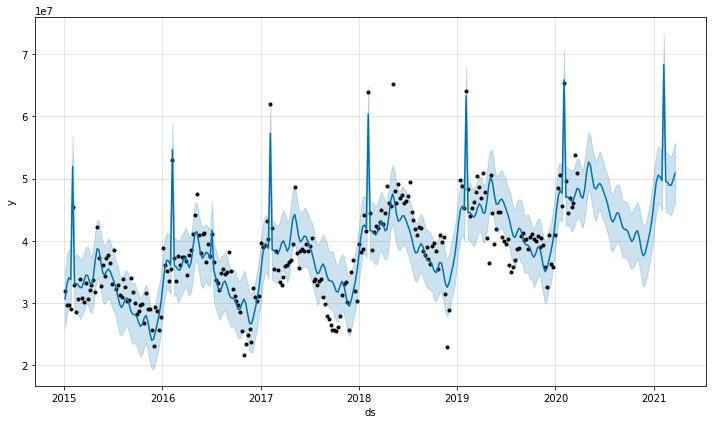

In [18]:
m = Prophet(holidays=holidays, weekly_seasonality=False,  daily_seasonality=False)
m.fit(avocado_prophet);
future = m.make_future_dataframe(periods=52, freq = 'W-Sun')
forecast = m.predict(future)
fig1 = m.plot(forecast)

The spikes near the Superbowl are now clearly captured by the model.

<a id='seasonality-and-multi-trend'></a>
## VI. Seasonality and Multi-trend

### i. Prophet (Multi-trend)

Time series often have trends that change over time. Prophet has built-in methods to identify trend changepoints and to visualize weekly, monthly, and yearly patterns.

In [19]:
# Format vehicle theft data for Prophet
vehicle_prophet = vehicle.reset_index().rename(columns = {'Date':'ds', 'Reported Incidents':'y'})
m = Prophet(daily_seasonality=False)

We might expect that vehicle thefts are affected by holidays. Prophet allows us to add all US Holidays at once to the model.

In [20]:
# Add all US holidays to the model
m.add_country_holidays(country_name = 'US')
m.fit(vehicle_prophet)

# Let's take a look at the holidays we've added.
m.train_holiday_names

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11      New Year's Day (Observed)
12        Veterans Day (Observed)
13    Independence Day (Observed)
dtype: object

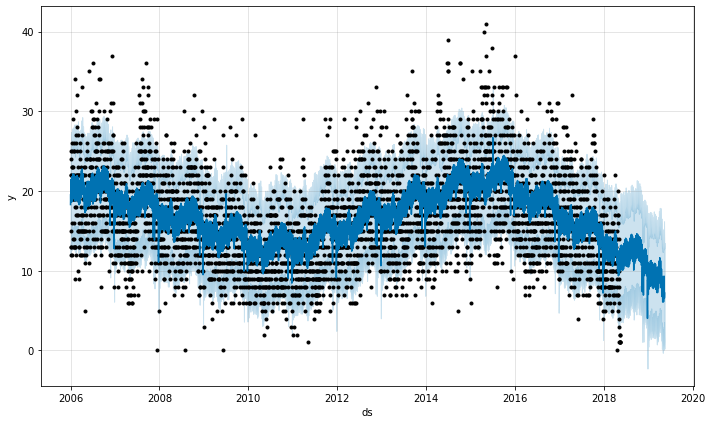

In [21]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)

We can break our Prophet model down into the trend, holidays, weekly, and yearly components that are summed together to make the model.

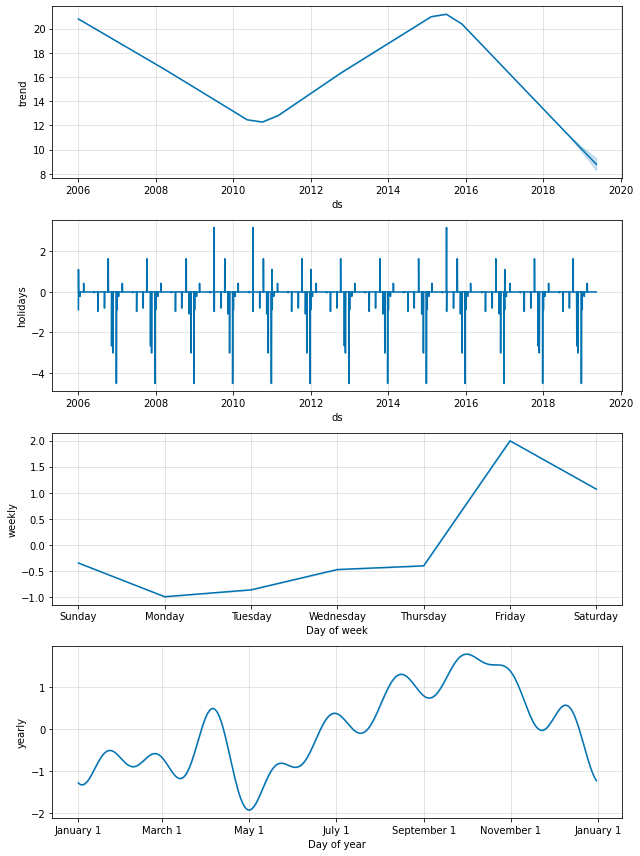

In [22]:
fig2 = m.plot_components(forecast)

References/Additional Reading:
- Detailed Overview: https://www.youtube.com/watch?v=kKg2OUVxbSA
- Github Source Code: https://github.com/facebook/prophet

